In [1]:
# widen jupyter notebook window
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:75% !important; }</style>"))

In [2]:
import sys
import os

import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

import matplotlib.pyplot as plt

import time
from IPython.display import clear_output


# # Import TensorLy
# import tensorly as tl
# from tensorly.tucker_tensor import tucker_to_tensor
# from tensorly.random import check_random_state

In [3]:
sys.path.insert(0, '/media/rich/Home_Linux_partition1/github_repos/tensorly')

import tensorly as tl
import tensorly.decomposition
import tensorly.random


In [4]:
import platform; print(platform.platform())
import sys; print("Python", sys.version)
import numpy; print("NumPy", numpy.__version__)
import scipy; print("SciPy", scipy.__version__)
import tensorly; print("TensorLy", tensorly.__version__)
import torch; print("PyTorch", torch.__version__)

Linux-5.4.0-56-generic-x86_64-with-glibc2.10
Python 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
NumPy 1.19.2
SciPy 1.5.2
TensorLy 0.5.0
PyTorch 1.7.0


In [5]:
tl.set_backend('pytorch')

In [6]:
random_state = 1234
rng = tensorly.random.check_random_state(random_state)
num_cpuCores = len(os.sched_getaffinity(0))
# device = 'cuda' if torch.cuda.device_count() > 0 else 'cpu'
device = 'cuda:0'
torch.cuda.current_device()

0

In [3]: torch.cuda.device(0)
Out[3]: <torch.cuda.device at 0x7efce0b03be0>

In [4]: torch.cuda.device_count()
Out[4]: 1

In [5]: torch.cuda.get_device_name(0)
Out[5]: 'GeForce GTX 950M'

In [6]: torch.cuda.is_available()
Out[6]: True
    
torch.device
# device = 'cpu'
# print(device)

In [7]:
# ### import data

# dir_factors_np = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run3'
# fileName_factors_np = f'factors_np.npy'
# path_factors_np = f'{dir_factors_np}/{fileName_factors_np}'
# factors_np = np.load(path_factors_np , allow_pickle=True)
# print(f'inputTensor shape: {factors_np.shape}')

In [8]:
### import data

dir_inputTensor = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run6'
fileName_inputTensor = f'Sxx_allPixels.npy'
path_inputTensor = f'{dir_inputTensor}/{fileName_inputTensor}'
inputTensor = np.load(path_inputTensor)
# inputTensor = torch.tensor(inputTensor , device=device)
# inputTensor = torch.tensor(inputTensor , device='cpu').pin_memory()
inputTensor = torch.tensor(inputTensor , dtype=tl.float32 , requires_grad=False)
# inputTensor = inputTensor
print(f'inputTensor shape: {inputTensor.shape}')

inputTensor shape: torch.Size([526, 50, 29323, 2])


In [9]:
# # tensor = tl.tensor(inputTensor[:,:,:4500, :] , device=device , dtype=tl.float32 , requires_grad=True)
# tensor = torch.tensor(inputTensor[:,:,:4500, :] , device=device , dtype=tl.float32 , requires_grad=True)
# # tensor = tl.tensor(tensor[ , device=device , requires_grad=True)

import gc

del inputTensor
gc.collect()

In [10]:
rank_toUse = 8
ranks = [rank_toUse , rank_toUse, rank_toUse , rank_toUse]
# core = tl.tensor(rng.random_sample(ranks), device=device, requires_grad=True)

# factors = [tl.tensor(rng.random_sample((tensor.shape[i], ranks[i])),
#                  device=device, requires_grad=True) for i in range(tl.ndim(tensor))]

weights = tl.tensor(np.ones(rank_toUse) , device=device, dtype=tl.float32, requires_grad=True)
# weights = tl.tensor(np.ones(rank_toUse) , device="cuda:0", dtype=tl.float32, requires_grad=True)

In [11]:
from torch.utils.data import Dataset, DataLoader
import copy
   
### Make dataset objects

class make_batchSlices_dataObj(Dataset):
    def __init__(self, input_tensor):
        """
        Args:
            input_tensor (tensor type): for now, this is a variable (in the memory) that should be pre-loaded in
        """
        self.tensor_full = input_tensor
    def __len__(self):
        return self.tensor_full.shape[2]
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()        
#         tensor_slice = torch.tensor( self.tensor_full[:,:,idx,:] , dtype=torch.float32 , device=device , requires_grad=True )
#         tensor_slice = self.tensor_full[:,:,idx,:]
#         tensor_slice = torch.tensor(self.tensor_full[:,:,idx,:] , device=device , dtype=torch.float32 , requires_grad=True)
#         return tensor_slice , idx
        return idx
    
# class make_batchFilaments_dataObj(Dataset):
#     def __init__(self, input_tensor):
#         """
#         Args:
#             input_tensor (tensor type): for now, this is a variable (in the memory) that should be pre-loaded in
#         """
#         self.tensor_full = input_tensor
#         self.shape_tensor = self.tensor_full.shape
#     def __len__(self):
#         return self.shape_tensor[0] * self.shape_tensor[1] * self.shape_tensor[3]
#     def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()     
#         idx_subscripts = np.unravel_index([idx], (batchFilaments_dataObj.shape_tensor[0] , batchFilaments_dataObj.shape_tensor[1] , batchFilaments_dataObj.shape_tensor[3]) , order='F') # order='F' necessary to make it (dim 0 , dim1 , dim2, ...)
#         idx_subscripts = np.array(idx_subscripts)[:,0]
        
#         tensor_filament = torch.tensor( self.tensor_full[idx_subscripts[0],idx_subscripts[1],:,idx_subscripts[2]] , dtype=torch.float32 , device=device , requires_grad=True )
#         return tensor_filament , idx , idx_subscripts

In [12]:
from torch.utils.data.dataloader import default_collate

    
batch_size = int(np.floor(inputTensor.shape[2]/ 1.6))

batchSlices_dataObj = make_batchSlices_dataObj(inputTensor)
dataloader_batchSlices = DataLoader(batchSlices_dataObj, batch_size=batch_size, drop_last=True
                        , shuffle=True
#                         , num_workers=num_cpuCores
                        , num_workers=0
#                         , pin_memory=True
#                         , collate_fn=lambda x: default_collate(x).to(device) 
                                   )

# batchFilaments_dataObj = make_batchFilaments_dataObj(inputTensor)
# dataloader_batchFilaments = DataLoader(batchFilaments_dataObj, batch_size=1, drop_last=True,
#                         shuffle=True, num_workers=0)

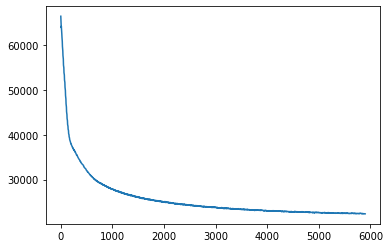

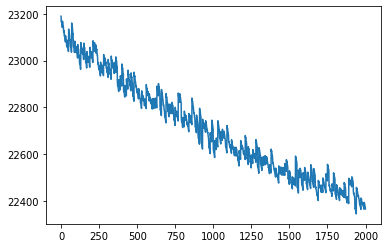

Epoch: 590  ,  Batch position: 1/1.6000763941940412  ,  Repeat Num: 9  Rec. error: 0.3068401515483856  ,  loss: 22366.88671875


KeyboardInterrupt: 

In [14]:
#basic libary
%matplotlib inline

# torch.multiprocessing.set_start_method('spawn')# good solution !!!!

##Define Function and class to be used
eps = 1.3e-7  # Slightly higher than min value of fp32
prox_plus = nn.Threshold(0,eps) ## to make all output postive 

class NTF(nn.Module): ## Model
    def __init__(self):
        super(NTF, self).__init__()

#         self.factors = nn.ParameterList([nn.Parameter(torch.tensor(rng.random_sample((tensor.shape[i], ranks[i])) , device='cuda:0').double(), requires_grad=True) for i in range(tensor.ndim)])
        
#         self.factors = [tl.tensor(rng.random_sample((tensor.shape[i], ranks[i])), device='cuda:0', requires_grad=True) for i in range(tl.ndim(tensor))]

           
        self.factors1 = nn.Parameter(torch.tensor(rng.random_sample((inputTensor.shape[0], ranks[0])) , dtype=tl.float32 , device=device), requires_grad=True) 
        self.factors2 = nn.Parameter(torch.tensor(rng.random_sample((inputTensor.shape[1], ranks[1])) , dtype=tl.float32 , device=device), requires_grad=True) 
        self.factors3 = nn.Parameter(torch.tensor(rng.random_sample((inputTensor.shape[2], ranks[2])) , dtype=tl.float32 , device=device), requires_grad=True) 
        self.factors4 = nn.Parameter(torch.tensor(rng.random_sample((inputTensor.shape[3], ranks[3])) , dtype=tl.float32 , device=device), requires_grad=True) 
        
    def forward(self , idx):
#             tmp = list((self.factors3.relu() , self.factors1.relu() , self.factors2.relu() , self.factors4.relu()))
#             tmp = list((self.factors3[idx,:].relu() , self.factors1.relu() , self.factors2.relu() , self.factors4.relu()))
#             tmp = list((self.factors3[idx,:] , self.factors1 , self.factors2 , self.factors4))
#         tmp = list((prox_plus(self.factors3[idx,:]) , prox_plus(self.factors1) , prox_plus(self.factors2) , prox_plus(self.factors4)))
        tmp = list( (prox_plus(self.factors1) , prox_plus(self.factors2) , prox_plus(self.factors3[idx,:]) ,prox_plus(self.factors4)) )
        
        

        
#         reconstruction = prox_plus(tl.cp_tensor.cp_to_tensor((weights, tmp)))
        reconstruction = tl.cp_tensor.cp_to_tensor((weights, tmp))
        return reconstruction


            
            
print('Start training on Task 1...')
# plt.figure()

ntf_obj = NTF()
ntf_obj.cuda()
loss_rolling=[] #collect loss

n_epoch =5000
# lr = 0.005
# lr = 0.02
lr_batch = 0.02
lr_nonBatch = 0.02

pref_regularization = 1
penalty_L1 = 0.00
penalty_L2 = 0.05

weight_decay = 0.005
# loss_fn = nn.MSELoss(reduction='sum')


# optimizer = optim.SGD(((ntf_obj.factors1, ntf_obj.factors2 , ntf_obj.factors3 , ntf_obj.factors4)),  lr=lr)
optimizer_batchParam    = torch.optim.Adam([ntf_obj.factors3]  ,  lr=lr_batch , weight_decay=weight_decay)
optimizer_nonBatchParams    = torch.optim.Adam(((ntf_obj.factors1, ntf_obj.factors2 , ntf_obj.factors4))  ,  lr=lr_nonBatch , weight_decay=weight_decay)
num_repeats_per_batch = 10

length_factors3 = ntf_obj.factors3.shape[0]
for epoch in range(n_epoch):
#     torch.cuda.empty_cache()
    ntf_obj.factors1.requires_grad = True
    ntf_obj.factors2.requires_grad = True
    ntf_obj.factors3.requires_grad = True
    ntf_obj.factors4.requires_grad = True
#     for iter_batchSlices , (tensor_batchSlices, idx_batchSlices)   in   enumerate(dataloader_batchSlices):
    optimizer_nonBatchParams.zero_grad() # need to clear the old gradients
    for iter_batchSlices , idx_batchSlices   in   enumerate(dataloader_batchSlices):
        idx_batchSlices_bool = np.in1d(np.arange(length_factors3) , idx_batchSlices)
        factors3_frozen = ntf_obj.factors3.clone().detach()
        tensor_batchSlices = inputTensor[:,:,idx_batchSlices,:].to(device)
        
        for iter_repeats in range(num_repeats_per_batch):
            optimizer_batchParam.zero_grad() # need to clear the old gradients
            Y_ = ntf_obj(idx_batchSlices)
            loss = tl.norm((Y_ - tensor_batchSlices), 2)

            if pref_regularization:
                for param in ntf_obj.parameters():
            #         loss = loss + penalty_L2 * param.data.pow(2).sum()
                    l1_regularization = penalty_L1 * torch.norm(param.data, 1)
                    l2_regularization = penalty_L2 * (torch.norm(param.data, 2)**2)
                    loss = loss + l1_regularization + l2_regularization
            loss.backward(retain_graph=True)

            loss_rolling.append(loss.detach())
            optimizer_batchParam.step()
        if(iter_batchSlices%5==0):
    #         print(loss)
    #         print(f'loss = {loss.cpu().detach().numpy()[None][0]}')
    #             rec_error = loss/tl.norm(goal_tensor, 2)
            rec_error = loss.detach()/tl.norm(tensor_batchSlices.detach(),2)
#             rec_error = 0
    #             print("Epoch {}  ,  Rec. error: {}  ,  loss: {}".format(epoch, rec_error, loss))
            clear_output()
            plt.plot(loss_rolling)
            plt.show()
            plt.plot(loss_rolling[-2000:])
            plt.show()
            print("Epoch: {}  ,  Batch position: {}/{}  ,  Repeat Num: {}  Rec. error: {}  ,  loss: {}".format(epoch+1, iter_batchSlices+1 , length_factors3/batch_size , iter_repeats , rec_error , loss))
        with torch.no_grad():
            ntf_obj.factors3[~idx_batchSlices_bool,:] = factors3_frozen[~idx_batchSlices_bool,:]
    optimizer_nonBatchParams.step()


In [20]:
torch.cuda.empty_cache()

In [15]:
with torch.no_grad():
    ntf_obj.factors3[~idx_batchSlices_bool,:] = factors3_frozen[~idx_batchSlices_bool,:]

factors_np = list(np.zeros(4))
for ii , param in enumerate(ntf_obj.parameters()):
    factors_np[ii] = param.relu().cpu().detach().numpy()
    

<IPython.core.display.Javascript object>


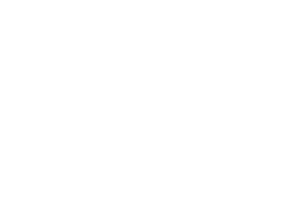

Final loss on Task 1: 
tensor(22366.8867, device='cuda:0')


<IPython.core.display.Javascript object>


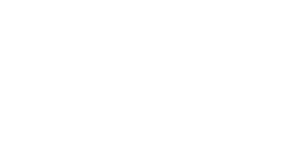

In [16]:
%matplotlib notebook
%matplotlib notebook
plt.figure()
plt.plot(loss_rolling[1:])
plt.ylabel('loss over time')
plt.xlabel('repeat (sub-iteration) #')
plt.show()

print('Final loss on Task 1: ')
print(loss_rolling[-1])

In [17]:
factors_np = np.load(f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run2/factors_np.npy' , allow_pickle=True)

In [19]:
np.save(f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run6/factors_np_batchCPsqrt.npy' , factors_np , allow_pickle=True)

/home/rich/miniconda3/envs/torch_env/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


<IPython.core.display.Javascript object>


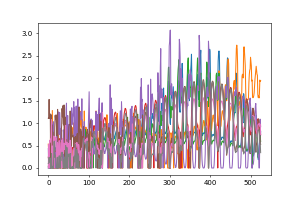

<IPython.core.display.Javascript object>


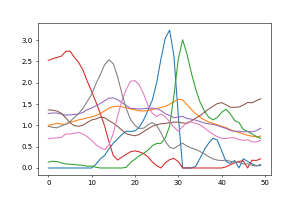

<IPython.core.display.Javascript object>


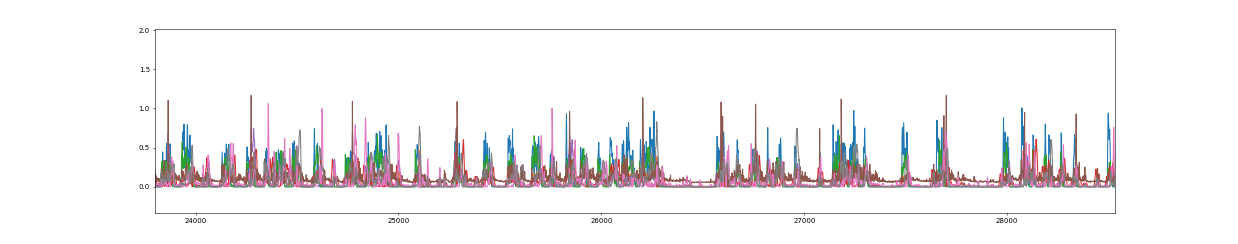

<IPython.core.display.Javascript object>


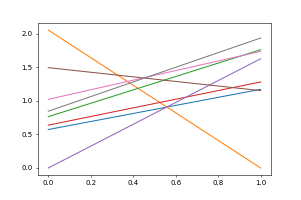

In [18]:
#### import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib notebook

plt.figure()
plt.plot(factors_np[0])
plt.figure()
plt.plot(factors_np[1])
plt.figure()
plt.plot(factors_np[2])
plt.figure()
plt.plot(factors_np[3])


In [ ]:
torch.cuda.empty_cache()